In [1]:
import calliope
import warnings
import Graphs as gg

In [2]:
try:
    calliope.set_log_level('INFO')
except:
    calliope.set_log_verbosity('INFO')
model = calliope.Model('model.yaml')
model.run()

[2020-08-17 14:29:47] INFO     Model: initialising
[2020-08-17 14:29:47] WARNING  C:\Users\Amin\Anaconda3\envs\calliope\lib\site-packages\calliope\core\preprocess\model_run.py:227: FutureWarning:

There will be no default cost class for the objective function in v0.7.0 (currently "monetary" with a weight of 1). Explicitly specify the cost class(es) you would like to use under `run.objective_options.cost_class`. E.g. `{"monetary": 1}` to replicate the current default.


[2020-08-17 14:29:47] INFO     Model: preprocessing stage 1 (model_run)
[2020-08-17 14:29:48] INFO     NumExpr defaulting to 4 threads.
[2020-08-17 14:29:48] INFO     Model: preprocessing stage 2 (model_data)
[2020-08-17 14:29:48] INFO     Model: preprocessing complete
[2020-08-17 14:29:48] INFO     Backend: starting model run
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (lifetime) to be 'Any', you can suppress
    this warning by explicitly specifying 

    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (resource_unit) to be 'Any', you can
    suppress this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0)
[2020-08-17 14:29:51] WARNING  DEPRECATED: The default domain for Param objects is 'Any'.  However,
we will be changing that default to 'Reals' in the future.  If you
really intend the domain of this Param (resource_unit) to be 'Any',
you can suppress this warning by explicitly specifying 'within=Any' to
the Param constructor.  (deprecated in 5.6.9, will be removed in 6.0)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (resource_unit) to be 'Any', you can
    suppress this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0)
[2020-08-17 14:29:51] WARNING  DEPRECATE

    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (lookup_remotes) to be 'Any', you can
    suppress this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0)
[2020-08-17 14:29:51] WARNING  DEPRECATED: The default domain for Param objects is 'Any'.  However,
we will be changing that default to 'Reals' in the future.  If you
really intend the domain of this Param (lookup_remotes) to be 'Any',
you can suppress this warning by explicitly specifying 'within=Any' to
the Param constructor.  (deprecated in 5.6.9, will be removed in 6.0)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (lookup_remotes) to be 'Any', you can
    suppress this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0)
[2020-08-17 14:29:51] WARNING  DEPREC

    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (colors) to be 'Any', you can suppress
    this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0)
[2020-08-17 14:29:51] WARNING  DEPRECATED: The default domain for Param objects is 'Any'.  However,
we will be changing that default to 'Reals' in the future.  If you
really intend the domain of this Param (colors) to be 'Any', you can
suppress this warning by explicitly specifying 'within=Any' to the
Param constructor.  (deprecated in 5.6.9, will be removed in 6.0)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (colors) to be 'Any', you can suppress
    this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0)
[2020-08-17 14:29:51] WARNING  DEPRECATED: The default domain

    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (inheritance) to be 'Any', you can
    suppress this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0)
[2020-08-17 14:29:51] WARNING  DEPRECATED: The default domain for Param objects is 'Any'.  However,
we will be changing that default to 'Reals' in the future.  If you
really intend the domain of this Param (inheritance) to be 'Any', you
can suppress this warning by explicitly specifying 'within=Any' to the
Param constructor.  (deprecated in 5.6.9, will be removed in 6.0)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (inheritance) to be 'Any', you can
    suppress this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0)
[2020-08-17 14:29:51] WARNING  DEPRECATED: The

    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (names) to be 'Any', you can suppress this
    warning by explicitly specifying 'within=Any' to the Param constructor.
    (deprecated in 5.6.9, will be removed in 6.0)
[2020-08-17 14:29:51] WARNING  DEPRECATED: The default domain for Param objects is 'Any'.  However,
we will be changing that default to 'Reals' in the future.  If you
really intend the domain of this Param (names) to be 'Any', you can
suppress this warning by explicitly specifying 'within=Any' to the
Param constructor.  (deprecated in 5.6.9, will be removed in 6.0)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (names) to be 'Any', you can suppress this
    warning by explicitly specifying 'within=Any' to the Param constructor.
    (deprecated in 5.6.9, will be removed in 6.0)
[2020-08-17 14:29:51] WARNING  DEPRECATED: The default domain for 

    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (lookup_loc_carriers) to be 'Any', you can
    suppress this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0)
[2020-08-17 14:29:51] WARNING  DEPRECATED: The default domain for Param objects is 'Any'.  However,
we will be changing that default to 'Reals' in the future.  If you
really intend the domain of this Param (lookup_loc_carriers) to be
'Any', you can suppress this warning by explicitly specifying
'within=Any' to the Param constructor.  (deprecated in 5.6.9, will be
removed in 6.0)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (lookup_loc_carriers) to be 'Any', you can
    suppress this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0)
[2020-08-17 14:29:51] 

    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (lookup_loc_techs) to be 'Any', you can
    suppress this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0)
[2020-08-17 14:29:51] WARNING  DEPRECATED: The default domain for Param objects is 'Any'.  However,
we will be changing that default to 'Reals' in the future.  If you
really intend the domain of this Param (lookup_loc_techs) to be 'Any',
you can suppress this warning by explicitly specifying 'within=Any' to
the Param constructor.  (deprecated in 5.6.9, will be removed in 6.0)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (lookup_loc_techs) to be 'Any', you can
    suppress this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0)
[2020-08-17 14:29:51] WARNING  

    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (lookup_loc_techs) to be 'Any', you can
    suppress this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0)
[2020-08-17 14:29:51] WARNING  DEPRECATED: The default domain for Param objects is 'Any'.  However,
we will be changing that default to 'Reals' in the future.  If you
really intend the domain of this Param (lookup_loc_techs) to be 'Any',
you can suppress this warning by explicitly specifying 'within=Any' to
the Param constructor.  (deprecated in 5.6.9, will be removed in 6.0)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (lookup_loc_techs) to be 'Any', you can
    suppress this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0)
[2020-08-17 14:29:51] WARNING  

    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (lookup_loc_techs) to be 'Any', you can
    suppress this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0)
[2020-08-17 14:29:51] WARNING  DEPRECATED: The default domain for Param objects is 'Any'.  However,
we will be changing that default to 'Reals' in the future.  If you
really intend the domain of this Param (lookup_loc_techs) to be 'Any',
you can suppress this warning by explicitly specifying 'within=Any' to
the Param constructor.  (deprecated in 5.6.9, will be removed in 6.0)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (lookup_loc_techs) to be 'Any', you can
    suppress this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0)
[2020-08-17 14:29:51] WARNING  

In [3]:
import pandas as pd

In [4]:
Dem_Tech = pd.read_excel('Graph_inputs.xlsx',sheet_name = 'Consumption Techs',index_col=[0],header=[0])
Nodes    = pd.read_excel('Graph_inputs.xlsx',sheet_name = 'Nodes',index_col=[0],header=[0])
Pr_Techs = pd.read_excel('Graph_inputs.xlsx',sheet_name = 'Production Techs',index_col = [0],header=[0])
colname  = pd.read_excel('Graph_inputs.xlsx',sheet_name = 'Col_Name',index_col = [0],header =[0])
imp_exp  = pd.read_excel('Graph_inputs.xlsx',sheet_name = 'imp-exp',index_col = [0],header =[0])
Trans    = pd.read_excel('Graph_inputs.xlsx',sheet_name = 'Transmission',index_col = [0],header =[0])
date     = pd.read_excel('Graph_inputs.xlsx',sheet_name = 'Date',index_col = [0],header =[0])

In [5]:
co_techs = Dem_Tech['Tech'].to_list()
carr     = Dem_Tech['Carrier'].to_list()
nodes    = Nodes['Location'].to_list()
pr_techs = Pr_Techs['Tech'].to_list()
colors   = colname['Color']
names    = colname['Name']
imps     = imp_exp['Imports'].to_list()
exps     = imp_exp['Exports'].to_list()
tr_tech  = Trans['Tech'].to_list()
start    = date['Value'][0]
end      = date['Value'][1]

In [ ]:
# How to build the transmissions

In [6]:
pr = model.get_formatted_array('carrier_prod').loc[{'techs':pr_techs,'carriers':'power','locs':[nodes[0]]}].sum('locs').to_pandas().T
pr = pd.concat([pr],keys=[nodes[0]],axis=1)
for i in  range (1,len(nodes)):
    pr0 = model.get_formatted_array('carrier_prod').loc[{'techs':pr_techs,'carriers':'power','locs':[nodes[i]]}].sum('locs').to_pandas().T
    pr0 = pd.concat([pr0],keys=[nodes[i]],axis=1)
    pr = pd.concat([pr,pr0],axis=1)
    
    
    

In [7]:
node = nodes[0]

r_nodes = nodes.copy()
r_nodes.remove(node)

exp = r_nodes.copy()
imp = r_nodes.copy()
    
node_index = []
    
for j in range(len(r_nodes)):
        
    node_index.append(nodes[0]) 
    node_index.append(nodes[0]) 
        
    exp[j] = exp[j] + '_exp'
    imp[j] = imp[j] + '_imp'

exports = pd.DataFrame(index=pr.index,columns=exp)
imports = pd.DataFrame(index=pr.index,columns=imp)


tran_get = []

for i in r_nodes:
    tr = []
    for j in tr_tech:
        tr.append(j + ':' + i)
    tran_get.append(tr)

for i in range(len(exp)):
    exports[exp[i]] = model.get_formatted_array('carrier_con').loc[{'techs':tran_get[i],'carriers':carr,'locs':[node]}].sum('locs').sum('techs').to_pandas().T
    imports[imp[i]] = model.get_formatted_array('carrier_prod').loc[{'techs':tran_get[i],'carriers':carr,'locs':[node]}].sum('locs').sum('techs').to_pandas().T

imports = pd.concat([imports],keys=[node],axis=1)
exports = pd.concat([exports],keys=[node],axis=1)
    
for i in range(1,len(nodes)):
    node = nodes[i]
    r_nodes = nodes.copy()
    r_nodes.remove(node)
    
    
    exp = r_nodes.copy()
    imp = r_nodes.copy()
    
    node_index = []
    
    for j in range(len(r_nodes)):
        
        node_index.append(nodes[i]) 
        node_index.append(nodes[i]) 
        
        exp[j] = exp[j] + '_exp'
        imp[j] = imp[j] + '_imp'   
        
    exports0 = pd.DataFrame(0,index=pr.index,columns=exp)
    imports0 = pd.DataFrame(0,index=pr.index,columns=imp)
    

    tran_get = []

    for h in r_nodes:
        tr = []
        for p in tr_tech:
            tr.append(p + ':' + h)
        tran_get.append(tr)

    for n in range(len(exp)):
        exports0[exp[n]] = model.get_formatted_array('carrier_con').loc[{'techs':tran_get[n],'carriers':carr,'locs':[node]}].sum('locs').sum('techs').to_pandas().T
        imports0[imp[n]] = model.get_formatted_array('carrier_prod').loc[{'techs':tran_get[n],'carriers':carr,'locs':[node]}].sum('locs').sum('techs').to_pandas().T

    imports0 = pd.concat([imports0],keys=[node],axis=1)
    exports0 = pd.concat([exports0],keys=[node],axis=1)
    
    imports = pd.concat([imports,imports0],axis=1)
    exports = pd.concat([exports,exports0],axis=1)

In [8]:
demand = -model.get_formatted_array('carrier_con').loc[{'techs':co_techs,'carriers':carr,'locs':nodes}].sum('techs').sum('carriers').to_pandas().T

(array([735599.  , 735599.25, 735599.5 , 735599.75, 735600.  , 735600.25,
        735600.5 , 735600.75]),
 <a list of 8 Text major ticklabel objects>)

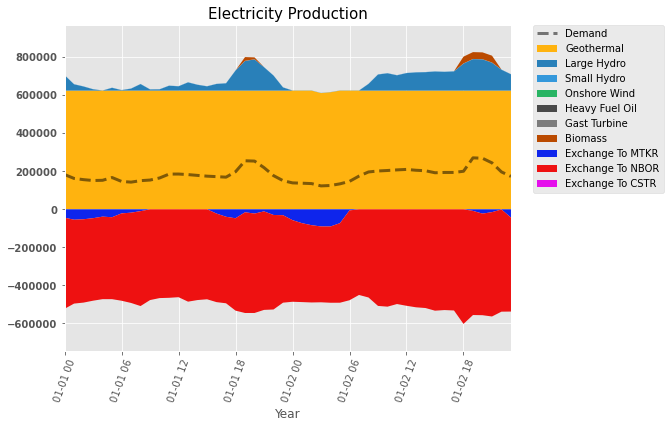

In [42]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

fig, (ax1) = plt.subplots(1, figsize=(8,6))
ax1.margins(x=0)
ax1.margins(y=0.1)

plt.plot(demand['WSTR'][start:end].index,demand['WSTR'][start:end].values,'black', alpha=0.5, linestyle = '--', label ='Demand',linewidth=3)

plt.stackplot(pr['WSTR'].index,pr['WSTR'].values.T,colors=col_list_pr,labels=name_list_pr)

plt.stackplot(pr['WSTR'].index,exports['WSTR'].values.T,colors=col_list_ex,labels=name_list_ex)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.,frameon=True)
plt.title("Electricity Production",fontsize=15)

plt.yticks(fontweight='bold')


plt.xlabel('Year')
plt.xticks(rotation=70)


In [22]:
colors

HFO_pp           #494949
GT_pp            #7C7C7C
geo_pp           #ffb30f
L_hydro_pp       #2980B9
S_hydro_pp       #3498DB
on_wind_pp       #28B463
bio_pp           #BA4A00
bio_coffee_pp    #592400
WSTR_imp         #75EE6B
MTKR_imp         #606FED
NBOR_imp         #ED6060
CSTR_imp         #EA6BEE
WSTR_exp         #22EB11
MTKR_exp         #0E25EC
NBOR_exp         #EE1111
CSTR_exp         #E50EEC
Name: Color, dtype: object

In [23]:
names

HFO_pp               Heavy Fuel Oil
GT_pp                 Gast Turbine 
geo_pp                   Geothermal
L_hydro_pp              Large Hydro
S_hydro_pp              Small Hydro
on_wind_pp             Onshore Wind
bio_pp                      Biomass
bio_coffee_pp        Coffee Biomass
WSTR_imp         Exchange From WSTR
MTKR_imp         Exchange From MTKR
NBOR_imp         Exchange From NBOR
CSTR_imp         Exchange From CSTR
WSTR_exp           Exchange To WSTR
MTKR_exp           Exchange To MTKR
NBOR_exp           Exchange To NBOR
CSTR_exp           Exchange To CSTR
Name: Name, dtype: object

In [39]:
col_list_pr = []
name_list_pr = []

for i in (prod):
    print(i)
    col_list_pr.append(colors[i])
    name_list_pr.append(names[i])

geo_pp
L_hydro_pp
S_hydro_pp
on_wind_pp
HFO_pp
GT_pp
bio_pp
MTKR_imp
NBOR_imp
CSTR_imp


In [24]:
prod = pd.concat([pr['WSTR'],imports['WSTR']],axis=1)


In [33]:
col_list_pr

['#ffb30f',
 '#2980B9',
 '#3498DB',
 '#28B463',
 '#494949',
 '#7C7C7C',
 '#BA4A00',
 '#606FED',
 '#ED6060',
 '#EA6BEE']

In [34]:
name_list_pr

['Geothermal',
 'Large Hydro',
 'Small Hydro',
 'Onshore Wind',
 'Heavy Fuel Oil',
 'Gast Turbine ',
 'Biomass',
 'Exchange From MTKR',
 'Exchange From NBOR',
 'Exchange From CSTR']

In [41]:
col_list_ex = []
name_list_ex = []

for i in (exports['WSTR']):
    print(i)
    col_list_ex.append(colors[i])
    name_list_ex.append(names[i])

MTKR_exp
NBOR_exp
CSTR_exp


In [38]:
prod

,geo_pp,L_hydro_pp,S_hydro_pp,on_wind_pp,HFO_pp,GT_pp,bio_pp,MTKR_imp,NBOR_imp,CSTR_imp
timesteps,,,,,,,,,,
2015-01-01 00:00:00,624000.000000,81033.966337,797.541667,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2015-01-01 01:00:00,624000.000000,32971.490454,797.541667,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2015-01-01 02:00:00,624000.000000,21358.767556,797.541667,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2015-01-01 03:00:00,624000.000000,6882.500965,797.541667,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2015-01-01 04:00:00,624000.000000,0.000000,797.541667,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2015-01-01 05:00:00,624000.000000,14597.008916,797.541667,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2015-01-01 06:00:00,624000.000000,2226.764682,797.541667,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2015-01-01 07:00:00,624000.000000,10244.495040,797.541667,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2015-01-01 08:00:00,624000.000000,34215.820911,797.541667,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
